## Import tools

In [68]:
# access the file system
import os
# deal with matrices
import numpy as np
# deal structured datasets
import pandas as pd
# deal with numerical computations
import scipy
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform
# deal with audio data
import librosa
from librosa.display import specshow
# play audio
import IPython.display as ipd
# display annotation
import mir_eval.display

# handle display
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

## Import data

In [69]:
song_name = "data/Beatles_YouCantDoThat"

# load annotation of the structure of the song
# start and end are expressed in seconds
df = pd.read_csv(song_name + ".csv", sep=";")

# load audio song
offset =  df['start'][0]
print(offset)
duration = df['end'][6]-offset

y, sr = librosa.load(song_name + ".wav", offset = offset, duration=duration)
sr

# align annotation with audio
df['end'] -= df['start'][0]
df['start'] -= df['start'][0]
df

7.765


,start,end,label
0,0.000,22.162,V
1,22.162,44.438,V
2,44.438,59.419,B
3,59.419,81.655,V
4,81.655,104.039,S
5,104.039,119.185,B
6,119.185,139.938,V


According to this annotation, we have 7 sections for this song.

**Question: what the letters of the label column stands for ?**

**Answer:** here

## Listen to some sections of the song

In [70]:
# play the section 6
start = int(df[df["label"]=="S"].start*sr)
end = int(df[df["label"]=="S"].end*sr)
ipd.Audio(y[start:end], rate=sr)

**Question:** Listen to the sections 0, 1, 3, and 6.

In [71]:
#### answer here
start = 
end = 
#### 

ipd.Audio(y[start:end], rate=sr)

**Questions:**
 - What do they have in common ?
 - Despite those similarities, something is different in section 8. Describe.

**Answer:** here

## Display the Constant Q transform of some sections

**Let us analyse those sections more analytically**

/Users/lagrange/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:981: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  out = axes.pcolormesh(x_coords, y_coords, data, **kwargs)


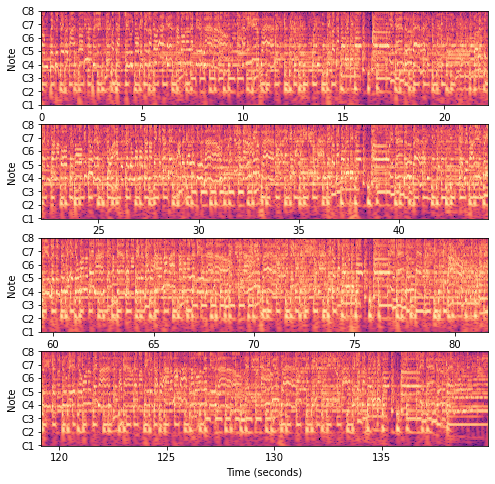

In [72]:
# select the sections with the "V" label: sections 2, 3, 5, and 8.
v = df[df["label"]=="V"]

# prepare a plot for each of those
fig, ax = plt.subplots(
    len(v), 1,
    figsize=(8, 8))

# and display the cqt
notes = ["C{}".format(str(i)) for i in range(1, 9)]
for v_id, row in enumerate(v.iterrows()):
    _, v = row
    a = y[int(v["start"]*sr):int(v["end"]*sr)]
    S = librosa.cqt(a, sr=sr)
    specshow(
        librosa.power_to_db(np.abs(S)),
        x_axis="s", y_axis="cqt_note", sr=sr,
        x_coords=v["start"]+librosa.times_like(S),
        ax=ax[v_id], cmap="magma", shading="auto")
    ax[v_id].set_yticks([
        librosa.note_to_hz(note)
        for note in notes
    ])
    ax[v_id].set_xlabel("")

ax[-1].set_xlabel("Time (seconds)")
plt.show()

**As you can see, the cqt plot after 145ms is rather different for section 8.**

**Question:** from your own listening, how can you describe this difference in the cqt display of section 8 ?

**Answer:** here

## Visualising similarities between segments of the song

In [73]:
# frame rate of the representation
hop_length = 1024
# compute the chroma representation of the song
C = librosa.feature.chroma_cqt(y, sr=sr, hop_length=hop_length)
# compute the self-similarity matrix
dC = squareform(pdist(C.T))

**Question:** complement the code below to display vertical and horizontal lines at boundaries between sections

In [ ]:
# plot the self-similarity matrix
plt.figure(figsize=(5, 5))
specshow(dC, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")

#### answer here

####
plt.show()

**Question:** can you identify motifs (recurring patterns) ? If yes, where ?

**Answer:** here

**Question:** the MFCCs are another way to represent audio data. Compute the corresponding distance matrix and plot it.

In [ ]:
#### answer here

####

**Question:** can you identify motifs (recurring patterns) using this other representation ? If yes, where ?

**Answer:** here

## Quantitative evaluation of representations

In [ ]:
# visualizing the structure of the song
intervals = np.stack((df["start"], df["end"]))
mir_eval.display.hierarchy([intervals.T], [df["label"]])
plt.xlabel("Time (seconds)")
plt.show()

In [ ]:
# reference vector
ref = np.zeros((C.shape[1], 1))
dic = {'I': 1, 'V': 2, 'B': 3, 'S': 4, 'O': 5}

for index, d in df.iterrows():
    start = int(d['start']*sr/hop_length)
    end = int(d['end']*sr/hop_length)
    ref[start:end] = dic[d['label']]

specshow(ref.T, x_axis="s", hop_length=hop_length)
plt.show()

**Question:** using this reference vector, compute a binary reference matrix of the same size than simC and simM with elements equals to 1 if a couple of segments are of the same type of section, zero otherwise.  

In [ ]:
#### answer here

####

specshow(dR, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")
plt.axis("square")
plt.show()

**Question:** compute the Mean Square Error (MSE) for the two representations. 

Hint: the matrice values must be in [0, 1].

In [ ]:
mseM = mean_squared_error(dR, dM / np.max(dM))
print("Mse for the MFCC representation: "+str(np.round(mseM, 4)))

mseC = mean_squared_error(dR, dC / np.max(dC))
print("Mse for the chroma representation: "+str(np.round(mseC, 4)))

**Question:** Are the numbers following your opinion ?

**Answer:** here

## Diagonal smoothing

Diagonal lines of low values in the self-distance distance matrix is a strong indicator of repetition. 

We can enhance those diagonal lines using the "checkerboard" filtering technique.

In [ ]:
# the checkerboard kernel
kernel_duration = 20 # in seconds
half_kernel_width = int(0.5*kernel_duration*sr // hop_length)
half_kernel = np.ones((half_kernel_width,))
full_kernel = np.concatenate((-half_kernel, half_kernel))
checkerboard = np.outer(full_kernel, full_kernel)
specshow(checkerboard, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")
plt.axis("square")
plt.colorbar()

**Question:** use this kernel and the fftconvolve method from scipy.signal in full mode to perform the filtering of the chroma based self-distance matrix. Display the result.

In [ ]:
#### answer here
dCc = 
####
specshow(dCc, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")
plt.show()

**Question**: Comment the dimensionality of the output as well as its structure.

Hint: filtering using fftconvolve assumes padding of zero values at boundaries.

**Answer:** here

**Question:** Compute the mse between the reference and the filtered matrix with the same dimensionality.

In [ ]:
#### answer here

####

# compute mse
dCcv -= np.min(dCcv)
dCcv /= np.max(dCcv)
mseCcv = mean_squared_error(dR, dCcv)
print("Mse for the checkerboard filtered chroma representation: "+str(np.round(mseCcv, 3)))

specshow(dCcv, cmap="magma")
plt.axis("square")
plt.show()

## Step by step 2D convolution

The code below implement the convolution using the 2D Fourier transform (convolution in the time domain is a multiplication in the spectral domain). 

**Question:** Fill the missing part of the algorithm.


In [ ]:
# Pad distance matrix
padding = checkerboard.shape[0]
#### answer here
dC_padded = np.pad(
####

# Pad checkerboard kernel
padding = dC.shape[0]
#### answer here
checkerboard_padded = np.pad(
####

# Map to 2-D Fourier domain
#### answer here
dC_fourier = 
checkerboard_fourier = 
####

# Pointwise multiplication in Fourier domain
dCc_fourier = dC_fourier * checkerboard_fourier

# Inverse 2-D Fourier transform (use the np.real operation discards nonzero artifacts in the imaginary part)
#### answer here
dCc_padded = 
####

# Unpad result
padding = checkerboard.shape[0]//2
#### answer here
dCc = 
####

# Display (we clip color values with plt.clim to improve visual contrast)
specshow(dCc, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")
plt.clim(np.min(dCc[padding:-padding, padding:-padding]), np.max(dCc[padding:-padding, padding:-padding]))

In [ ]:
# compute mse
dCc -= np.min(dCc)
dCc /= np.max(dCc)
mseCc = mean_squared_error(dR, dCc)
print("Mse for the checkerboard filtered chroma representation: "+str(np.round(mseCc, 3)))

**Question:** Visualize the magnitude of the checkerboard_fourier and dCc_fourier matrices and comment.

In [ ]:
#### answer here

####

**Answer:** here

## Cumulative sum

The code below performs the convolution  in an efficient manner. 

In [ ]:
kernel_duration = 20 # in seconds
T = int(0.5*kernel_duration*sr // hop_length)

# 2D cumulative sum
dC_padded = np.pad(dC, ((2*T, 2*T), (2*T, 2*T)))
S = np.cumsum(np.cumsum(dC_padded, axis=0), axis=1)

# average
A = S[T:, T:] + S[:-T,:-T] - S[T:, :-T] - S[:-T, T:]

# checkerboard
dCcCum = A[:-T, :-T] + A[T:, T:] - A[T:, :-T] - A[:-T, T:]

dCcCum = dCcCum[T:-T, T:-T]

plt.figure(figsize=(5, 5))
specshow(dCcCum, x_axis="s", y_axis="s", hop_length=hop_length, cmap="magma")
plt.clim(np.min(dCcCum[T:-T,T:-T]), np.max(dCcCum[T:-T,T:-T]))

In [ ]:
# compute mse
mseCc = mean_squared_error(dR, (dCc-np.min(dCc))/np.max(dCc))
print("Mse for the checkerboard filtered chroma representation: "+str(np.round(mseCc, 3)))

Describes your understanding of the different steps of the processing. 

**Answer:** here

Compare its complexity with respect to the two previous implementations. 

**Answer:** here

**Question:**  Compare the duration of the three procedures.

In [ ]:
#### answer here

####

**Question:**  Are the results in line with your complexity analysis ?

**Answer:** here